## Семинар 3. RNN и Трансформер

В этом семинаре мы научимся решать задачу машинного перевода с немецкого языка на английский. Для обучения мы будем использовать датасет [Multi30K](https://aclanthology.org/W16-3210/), содержащий около 30.000 текстов, описывающих изображения, и переводов к ним.

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import wandb

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Подготовка данных

[Multi30k](https://arxiv.org/abs/1605.00459) – самый популярный академический датасет для тестирования моделей машинного перевода. Попробуем и мы что-нибудь на нем протестировать.

Любые датасеты, которые лежат на платформе [Hugging Face](https://huggingface.co/datasets), можно скачать одной строчкой с помощью [`load_dataset`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/loading_methods#datasets.load_dataset)

In [4]:
from datasets import load_dataset

dataset = load_dataset("bentrevett/multi30k")
dataset

README.md:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [16]:
dataset['train'][0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

Сразу обернем все в `DataLoader`, чтобы потом удобно итерироваться по данным.

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset['train'], shuffle=True, batch_size=32)
test_loader = DataLoader(dataset['test'], shuffle=False, batch_size=32)

Обозначим с какого языка на какой переводим, чтобы точно потом не запутаться

In [6]:
SRC_NAME = 'de'
TRG_NAME = 'en'

### Токенизатор

Так как датасет достаточно маленький, мы вряд ли сможем построить по нему хороший токенизатор. Поэтому загрузим уже готовые для обоих языков из Hugging Face.

Любые токенизаторы из Hugging Face можно загрузить с помощью [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer). BERT – это модель вида Трансформер, мы обсудим ее подробно позже. `uncased` означает, что токенизатор не будет учитывать регистр (приведет все к нижнему).

In [7]:
from transformers import AutoTokenizer

tokenizers = {
    'en': AutoTokenizer.from_pretrained('bert-base-uncased'),
    'de': AutoTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')
}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Существуют два вида токенизаторов:
1. `Tokenizer` – реализован на Python из-за того, что это проще.
1. `TokenizerFast` – реализован на Rust с использованием библиотеки `tokenizers`. Чаще всего в 3-5 раз быстрее обычного.

По поведению оба токенизатора совпадают, поэтому по умолчанию всегда используется `TokenizerFast`, если он доступен.

In [70]:
tokenizers['en']

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Любой токенизатор можно импортировать явно.

In [71]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

При вызове токенизатора возвращается объект класса [BatchEncoding](https://huggingface.co/docs/transformers/v4.45.1/en/main_classes/tokenizer#transformers.BatchEncoding).

In [47]:
encoded = tokenizers['en']('Random text to encode')
type(encoded)

transformers.tokenization_utils_base.BatchEncoding

In [49]:
encoded.tokens(), encoded.word_ids()

(['[CLS]', 'random', 'text', 'to', 'en', '##code', '[SEP]'],
 [None, 0, 1, 2, 3, 3, None])

'[CLS]' – токен начала текста (аналог '[BOS]').   
'[SEP]' – токен конца текста (аналог '[EOS]')

In [48]:
encoded

{'input_ids': [101, 6721, 3793, 2000, 4372, 16044, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

`input_ids` – индексы токенов.   
`attention_mask` – маска, в которой 1 стоят на месте всех не паддингов. Она нужна при токенизации батча текстов с добавлением паддингов.   
`token_type_ids` – показывает, к какой части текса относится каждый токен. Нужно для некоторых задач обучения.

In [59]:
encoded = tokenizers['en'](
    ['First text to encode', 'Second text'],
    padding=True,        # добавить паддинг ко всем коротким текстам
    max_length=3,        # ограничиваем максимальную длину последовательности
    truncation=True,     # обрезать до максимальной длины
    return_token_type_ids=False,
    return_tensors='pt'  # возвращать torch тензоры
)
encoded

{'input_ids': tensor([[ 101, 2034,  102],
        [ 101, 2117,  102]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]])}

Можно получить только токены, если остальное не нужно.

In [60]:
encoded = tokenizers['en'].encode('Random text to encode')
encoded

[101, 6721, 3793, 2000, 4372, 16044, 102]

Для конвертации токенов обратно в текст можно использовать `.decode` (`.batch_decode` для батча текстов).

In [63]:
tokenizers['en'].decode(encoded)

'[CLS] random text to encode [SEP]'

In [64]:
tokenizers['en'].decode(encoded, skip_special_tokens=True)

'random text to encode'

Посмотрим на распределение длин текстов, чтобы лучше понять данные и знать, какой длины тексты надо генерировать.

In [19]:
de_lens = [len(tokenizers['de'].encode(text)) for text in dataset['train']['de']]
en_lens = [len(tokenizers['en'].encode(text)) for text in dataset['train']['en']]

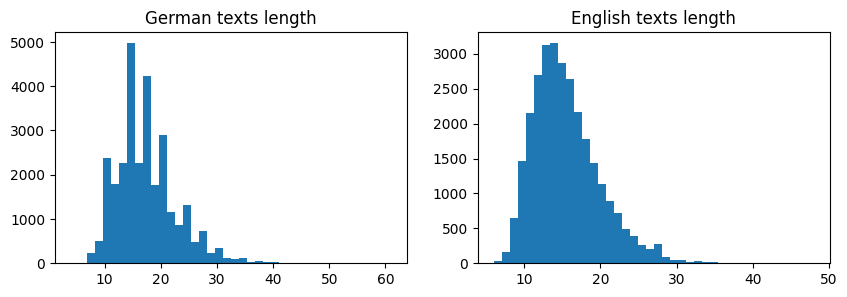

In [15]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(de_lens, bins=40)
plt.title('German texts length')

plt.subplot(1, 2, 2)
plt.hist(en_lens, bins=40)
plt.title('English texts length')

plt.show()

Из графиков видно, что почти все тексты имеют длину меньше 32 токенов, поэтому зафиксируем это значение. Оно пригодится нам позже.

In [9]:
MAX_LENGTH = 32

## Метрика качества BLEU

$$
BLEU(\hat{Y}, Y) = BP(\hat{Y}, Y) \cdot \exp\left(\sum_{n=1}^N w_n \ln p_n(\hat{Y}, Y) \right),
$$
где $p_n(\hat{Y}, Y)$ – точность (precision), a $n$ – размер n-граммы.

__Brevity penalty__ штрафует модель за коротные ответы.
$$
BP(\hat{Y}, Y) = \exp\bigg( -\left[\frac{\sum_{i=1}^m|y_i|}{\sum_{i=1}^m|\hat{y}_i|} - 1\right]_+ \bigg)
$$


Разных реализации BLEU существует очень много: ([moses](https://github.com/moses-smt/mosesdecoder/blob/master/scripts/generic/multi-bleu.perl), [nltk](https://www.nltk.org/_modules/nltk/translate/bleu_score.html), [sacrebleu](https://pypi.org/project/sacrebleu/), [huggingface](https://huggingface.co/spaces/evaluate-metric/bleu)). В основном они отличаются способами токенизации текстов и сглаживания, и обычно дают разные результаты для одинаковых данных. Поэтому для сравнения методов __очень важно__ использовать одинаковые реализации BLEU. Мы возьмем реализацию huggingface, чтобы не вводить новые библиотеки.

In [113]:
import evaluate
bleu_score = evaluate.load('bleu')

## LSTM

Рекуррентная нейронная сеть для Seq2seq выглядит вот так.

<img src="https://i.postimg.cc/xTvrvhJc/rnn-seq2seq.png" alt="drawing" width="700"/>

В нашей реализации мы сделаем Encoder двунаправленным, чтобы он мог считывать больше контекста. Из-за того, что между кодировщиком и декодировщиком имеется bottleneck, качество должно получиться не очень высоким.

In [89]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, hidden_size)
        # двунаправленный LSTM Encoder
        self.encoder = nn.LSTM(hidden_size, hidden_size, bidirectional=True, batch_first=True)
        # обычный LSTM Decoder
        self.decoder = nn.LSTM(hidden_size, hidden_size, bidirectional=False, batch_first=True)

        self.h_proj = nn.Linear(2 * hidden_size, hidden_size)
        self.c_proj = nn.Linear(2 * hidden_size, hidden_size)

        self.out_proj = nn.Linear(hidden_size, trg_vocab_size)

    def encode(self, input_ids, *args, **kwargs):
        bs = len(input_ids)

        input_embedded = self.embedding(input_ids)
        _, (h_enc, c_enc) = self.encoder(input_embedded)

        # h_enc: [2, bs, hidden_size]
        # первая размерность – число слоев
        h_enc = h_enc.permute(1, 0, 2).reshape(1, bs, -1) # [1, batch, 2 * hidden_size]
        c_enc = c_enc.permute(1, 0, 2).reshape(1, bs, -1) # [1, batch, 2 * hidden_size]

        h_enc = self.h_proj(h_enc)
        c_enc = self.c_proj(c_enc)

        return h_enc, c_enc

    def forward(self, input_ids, output_ids, *args, **kwargs):
        h_enc, c_enc = self.encode(input_ids)

        output_embedded = self.embedding(output_ids)
        dec_output, _ = self.decoder(output_embedded, (h_enc, c_enc))

        logits = self.out_proj(dec_output)
        return logits

    @torch.inference_mode()
    def generate(self, input_ids, *args, max_length=MAX_LENGTH, **kwargs):
        bs = len(input_ids)

        h_enc, c_enc = self.encode(input_ids)
        output_ids = [torch.full((bs,), tokenizers[TRG_NAME].cls_token_id, device=input_ids.device)]
        
        state = (h_enc, c_enc)

        for i in range(max_length):
            dec_input = self.embedding(output_ids[-1].unsqueeze(-1))
            dec_output, state = self.decoder(dec_input, state)
            logits = self.out_proj(dec_output)

            output_ids.append(logits.argmax(-1).squeeze(-1))

        output_ids = torch.stack(output_ids).T
        return output_ids

Вспомогательные функции для обучения и валидации. `clean_text` используется для очистки сгенерированных текстов. В том случае, когда генерируется целый батч, после токена '[SEP]' может оказаться куча мусорных токенов. Их нужно удалить.

In [110]:
def clean_text(texts):
    """
    Эта функция удаляет все токены (если есть) до [CLS] и после [SEP]
    """
    new_texts = []
    for text in texts:
        cls_pos = text.find('[CLS]')
        text = text[cls_pos + len('[CLS] '):]

        sep_pos = text.find(' [SEP]')
        if sep_pos != -1:
            text = text[:sep_pos]

        new_texts.append(text)

    return new_texts

In [11]:
def tokenize(batch):
    """
    Токенизируем входную и выходную последовательность.
    Обрезаем все тексты до максимальной длины.
    """
    tokenizer_kwargs = dict(
        padding=True,
        max_length=MAX_LENGTH,
        truncation=True,
        return_tensors='pt'
    )
    input = tokenizers[SRC_NAME](batch[SRC_NAME], **tokenizer_kwargs).to(device)
    output = tokenizers[TRG_NAME](batch[TRG_NAME], **tokenizer_kwargs).to(device)

    return input, output

def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """

    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizers[TRG_NAME].pad_token_id)

    for batch in dataloader:
        input, output = tokenize(batch)

        logits = model(
            input['input_ids'],
            output['input_ids'],
            input['attention_mask'],
            output['attention_mask']
        )

        # сдвигаем предсказания так, чтобы для каждого токена предсказывать следующий
        shifted_logits = logits[:, :-1]
        shifted_targets = output['input_ids'][:, 1:]

        # переставляем размерности логитов, так как в CrossEntropyLoss
        # предсказания классов должны быть второй размерностью
        loss = criterion(shifted_logits.permute(0, 2, 1), shifted_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # считаем точность в батче, игнорируя токены паддинга
        accuracy = (shifted_logits.argmax(-1) == shifted_targets).float()
        accuracy = accuracy[shifted_targets != tokenizers[TRG_NAME].pad_token_id].mean().item()

        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": accuracy
        })


@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """

    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizers[TRG_NAME].pad_token_id)

    accuracies = []
    losses = []
    text_predictions = []
    text_references = []
    for batch in dataloader:
        input, output = tokenize(batch)

        logits = model(
            input['input_ids'],
            output['input_ids'],
            input['attention_mask'],
            output['attention_mask']
        )

        shifted_logits = logits[:, :-1]
        shifted_targets = output['input_ids'][:, 1:]

        # переставляем размерности логитов, так как в CrossEntropyLoss
        # предсказания классов должны быть второй размерностью
        loss = criterion(shifted_logits.permute(0, 2, 1), shifted_targets)
        losses.append(loss.item())

        # Так не очень честно делать на валидации, так как число токенов может отличаться
        # для разных батчей. Из-за этого батчи должны весить по-разному.
        # Однако, нам точность нужна только для понимания того, как учится модель, так что это не страшно.
        tokens = shifted_logits.argmax(-1)
        accuracy = (tokens == shifted_targets).float()
        accuracy = accuracy[shifted_targets != tokenizers[TRG_NAME].pad_token_id].mean().item()
        accuracies.append(accuracy)

        gen_ids = model.generate(input['input_ids'], input['attention_mask'])
        text_predictions.extend(clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids)))
        text_references.extend(tokenizers[TRG_NAME].batch_decode(output['input_ids'], skip_special_tokens=True))

    bleu_results = bleu_score.compute(predictions=text_predictions, references=text_references)

    wandb.log({
        "test_loss": np.mean(losses),
        "test_accuracy": np.mean(accuracies),
        "BLEU": bleu_results['bleu']
    })

Инициализируем модель с оптимизатором и обучаем ее.

In [ ]:
model = Seq2SeqLSTM(len(tokenizers[SRC_NAME]), len(tokenizers[TRG_NAME]), 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print('All parameters:', sum([torch.numel(p) for p in model.parameters()]))
print('Non-embedding parameters:',
      sum([torch.numel(p) for p in model.parameters()]) - \
      torch.numel(model.embedding.weight) - \
      torch.numel(model.out_proj.weight)
)

All parameters: 8380474
Non-embedding parameters: 492602


In [ ]:
wandb.init(project="seminar3", name="lstm")

In [ ]:
for e in range(80):
    train(model, train_loader, optimizer)
    evaluate(model, test_loader)

In [ ]:
torch.save(model.state_dict(), 'lstm.pt')

Итоговое значение BLEU обученной LSTM на тестовом датасете: __0.152__, запомним его.

Посмотрим теперь на примеры перевода этой модели.

In [ ]:
model.eval();

In [ ]:
batch = next(iter(test_loader))
input, output = tokenize(batch)

In [ ]:
with torch.inference_mode():
    gen_ids = model.generate(input['input_ids'])
    preds = clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids))

In [ ]:
preds[:5]

['a man with a hard hat is standing in a public area.',
 'a dog swims is jumping over sand dune in front of an asian.',
 'a girl in a karate uniform is doing a trick.',
 'five people in helmets and helmets are standing in the snow and one is wearing yellow pants.',
 'people are looking at a train.']

In [ ]:
batch['de'][:5]

['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
 'Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.',
 'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.',
 'Leute Reparieren das Dach eines Hauses.']

In [ ]:
batch['en'][:5]

['A man in an orange hat starring at something.',
 'A Boston Terrier is running on lush green grass in front of a white fence.',
 'A girl in karate uniform breaking a stick with a front kick.',
 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
 'People are fixing the roof of a house.']

Видим, что текст выглядит грамотно и действующие персонажи перенеслись верно. Однако почти все действия не соответствуют правильному переводу.

Посмотрим теперь, удастся ли Трансформеру исправить эту проблему.

### Резюме

1. Собрали датасет и токенизаторы.
1. Выбрали метрику для проверки качества.
1. Обучили LSTM в качестве бейзлайна.

## Трансформер

Основная идея трансформера заключается в механизме внимания. Токены могут обмениваться между собой информацией, забирая только то, что им нужно.

<img src="https://i.postimg.cc/vTGK3H6T/transformer.png" alt="drawing" width="400"/>

In [23]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, hidden_size,
                 num_encoder_layers=1, num_decoder_layers=1, max_len=MAX_LENGTH):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, hidden_size)
        self.positional_embedding = nn.Embedding(max_len, hidden_size)

        # модель Трансформер можно загрузить из torch.nn
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=8,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=4 * hidden_size,
            batch_first=True
        )

        self.out_proj = nn.Linear(hidden_size, trg_vocab_size)

    def encode(self, input_ids, attention_mask=None):
        seq_len = input_ids.shape[1]

        # добавляем позиционные эмбеддинги
        input_embedded = self.embedding(input_ids)
        input_embedded += self.positional_embedding(torch.arange(seq_len, device=input_ids.device))[None, :]

        # кодируем входной текст с маской внимания, которая запрещает смотреть на токены паддинга 
        encoded = self.transformer.encoder(
            input_embedded,
            src_key_padding_mask=~attention_mask.bool() if attention_mask is not None else None)

        return encoded

    def decode(self, output_ids, encoded_input, src_attention_mask=None, trg_attention_mask=None):
        trg_seq_len = output_ids.shape[1]

        # добавляем позиционные эмбеддинги
        output_embedded = self.embedding(output_ids)
        output_embedded += self.positional_embedding(torch.arange(trg_seq_len, device=output_ids.device))[None, :]

        # генерируем треугольную маску внимания
        # каждый токен при декодировании может смотреть только на токены перед ним,
        # потому что иначе он будет смотреть в будущее
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(output_ids.device)

        # memory mask говорит, на какие токены входной последовательности можно смотреть
        dec_output = self.transformer.decoder(
            output_embedded,
            encoded_input,
            memory_key_padding_mask=~src_attention_mask.bool() if src_attention_mask is not None else None,
            tgt_mask=trg_mask,
            tgt_key_padding_mask=~trg_attention_mask.bool() if trg_attention_mask is not None else None
        )

        logits = self.out_proj(dec_output)

        return logits

    def forward(self, input_ids, output_ids, src_attention_mask, trg_attention_mask):
        encoded = self.encode(input_ids, src_attention_mask)
        logits = self.decode(output_ids, encoded, src_attention_mask, trg_attention_mask)

        return logits
    
    def generate(self, input_ids, src_attention_mask, max_length=MAX_LENGTH):
        """
        Жадно генерирует текст по аналогии с LSTM.
        """
        bs = len(input_ids)
        encoded = self.encode(input_ids, src_attention_mask)

        output_ids = torch.full((bs, 1), tokenizers[TRG_NAME].cls_token_id, device=input_ids.device)

        for i in range(max_length):
            logits = self.decode(output_ids, encoded, src_attention_mask)

            next_tokens = logits[:, -1].argmax(-1)
            finished += next_tokens == tokenizers[TRG_NAME].sep_token_id

            output_ids = torch.cat((output_ids, next_tokens.unsqueeze(-1)), dim=1)

        return output_ids

Переходим к обучению. Возьмем трансформер с __одним__ слоем такого же размера, что и LSTM. Так сравнение будет честным.

In [15]:
model = Seq2SeqTransformer(len(tokenizers[SRC_NAME]), len(tokenizers[TRG_NAME]), 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print('All parameters:', sum([torch.numel(p) for p in model.parameters()]))
print('Non-embedding parameters:',
      sum([torch.numel(p) for p in model.parameters()]) - \
      torch.numel(model.embedding.weight) - \
      torch.numel(model.out_proj.weight)
)

All parameters: 8385850
Non-embedding parameters: 497978


In [ ]:
wandb.init(project="seminar3", name="1layer_transformer")

In [ ]:
for e in range(60):
    train(model, train_loader, optimizer)
    evaluate(model, test_loader)

In [ ]:
torch.save(model.state_dict(), '1layer_transformer.pt')

Итоговое значение BLEU у этого Трансформера на тестовом датасете: __0.32__.   
Это __намного__ лучше, чем 0.152, которые были у LSTM!

На тех же примерах перевода можем убедиться, что модель теперь переносит __гораздо__ больше информации.

In [ ]:
model.eval();

In [ ]:
batch = next(iter(test_loader))
input, output = tokenize(batch)

In [ ]:
with torch.inference_mode():
    gen_ids = model.generate(input['input_ids'])
    preds = clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids))

In [5]:
preds[:5]

['a man with an orange hat working.',
 'a boston terrier runs across green grass in front of a white fence.',
 'a girl in a karate uniform is flipping a board with a board.',
 'five people in winter jackets and helmets are standing in the snow with snow.',
 'people are examining a rooftop of a house.']

In [ ]:
batch['de'][:5]

['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
 'Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.',
 'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.',
 'Leute Reparieren das Dach eines Hauses.']

In [ ]:
batch['en'][:5]

['A man in an orange hat starring at something.',
 'A Boston Terrier is running on lush green grass in front of a white fence.',
 'A girl in karate uniform breaking a stick with a front kick.',
 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
 'People are fixing the roof of a house.']

## Визуализация механизма внимания

Так как наш трансформер имеет только один слой, у него есть только один слой Cross Attention. Мы можем посмотреть для разных примеров, какие веса получаются внутри этого слоя внимания.

In [98]:
# Загружаем обученную модель

model = Seq2SeqTransformer(len(tokenizers[SRC_NAME]), len(tokenizers[TRG_NAME]), 128).to(device)
model.load_state_dict(torch.load('1layer_transformer.pt', map_location=torch.device('cpu')))
model.eval();

В этой модели нельзя так просто добраться до весов внимания, поэтому придется сделать костыльно. Мы переопределим функцию `_mha_block`, изменив параметр `need_weights` с `False` на `True`. Это нужно для того, чтобы этот слой возвращал веса внимания. После этого прокинем hook, чтобы можно было доставать выходы слоя `multihead_attn` после прогона модели.

In [99]:
from functools import partial

def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
    x = self.multihead_attn(x, mem, mem,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            is_causal=is_causal,
                            need_weights=True)[0]
    return self.dropout2(x)

model.transformer.decoder.layers[0]._mha_block = partial(_mha_block, model.transformer.decoder.layers[0])

In [100]:
attention_weights = {}
def get_attention_weights(name):
    def hook(model, input, output):
        attention_weights[name] = output[1].cpu()
    return hook

model.transformer.decoder.layers[0].multihead_attn.register_forward_hook(get_attention_weights('multihead_attn'))

Запускаем все и смотрим, что в `attention_weights['multihead_attn']` действительно попали веса внимания из Cross Attentioin.

In [104]:
with torch.inference_mode():
    logits = model(
        input['input_ids'], output['input_ids'],
        input['attention_mask'], output['attention_mask']
    )

att_weights = attention_weights['multihead_attn']
att_weights.shape, att_weights[0].sum(-1)

(torch.Size([32, 31, 32]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000]))

Теперь отобразим полученные матрицы для нескольких коротких примеров. По вертикали стоят токены целевого языка (английского), а по горизонтали входная последовательность (немецкий). Отлично видно, что для каждого английского токена (ряда) модель смотрит на следующий за ним токен из немецкого текста. Так и должно быть, потому что задача модели – предсказать следующий токен.

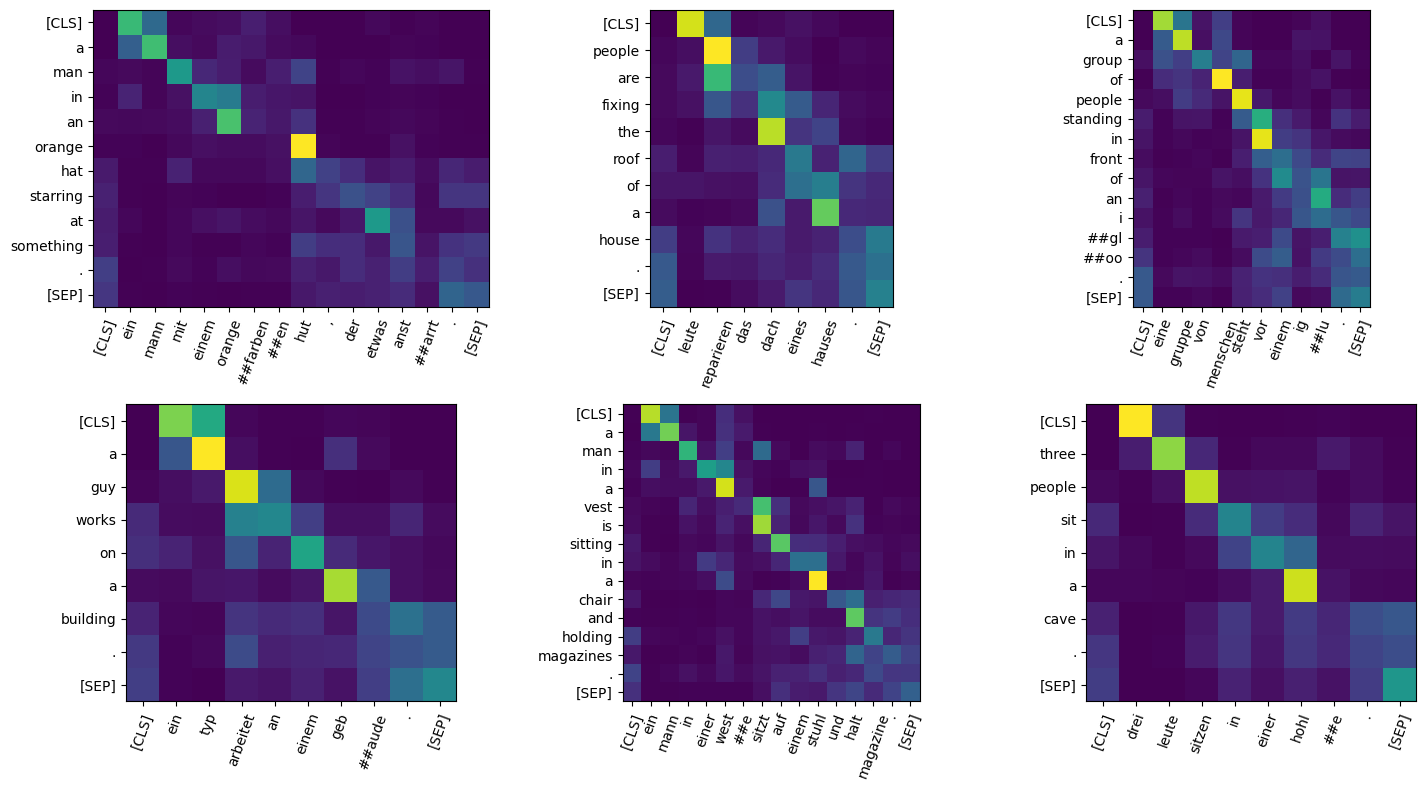

In [128]:
idxs = [0, 4, 6, 8, 9, 14]
n = len(idxs)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(idxs):
    plt.subplot(2, n // 2, i + 1)
    src_len = input['attention_mask'][idx].sum().item()
    trg_len = output['attention_mask'][idx].sum().item()

    src_tokens = tokenizers[SRC_NAME].convert_ids_to_tokens(input['input_ids'][idx])[:src_len]
    trg_tokens = tokenizers[TRG_NAME].convert_ids_to_tokens(output['input_ids'][idx])[:trg_len]

    plt.imshow(att_weights[idx, :trg_len, :src_len])
    plt.xticks(np.arange(src_len), src_tokens, rotation=70)
    plt.yticks(np.arange(trg_len), trg_tokens)

plt.tight_layout()

## Важность Cross Attention

Мы уже говорили, что основная проблема рекуррентных моделей для Seq2seq в том, что между Encoder'ом и Decoder'ом возникает bottleneck, из-за которого часть информации теряется. Cross Attention в Трансформере призван решать эту проблему, и из примера выше мы видим, что он выучивает что-то очень разумное.

Однако надо помнить, что в Трансформере есть еще Self-Attention, который тоже должен улучшать модель. Может быть Трансформер хорош только из-за него, а Cross Attention лишь немного помогает? Давайте проверим, насколько Cross Attention влияет на результат, убрав его из модели. Сделаем искусственный bottleneck, заставив декодер смотреть только на выход нулевого ([CLS]) токена.

In [77]:
class Seq2SeqTransformerNoCA(Seq2SeqTransformer):
    """
    То же самое, что и Seq2SeqTransformer.
    Меняется только способ декодирования.
    """
    
    def __init__(self, src_vocab_size, trg_vocab_size, hidden_size,
                 num_encoder_layers=1, num_decoder_layers=1, max_len=MAX_LENGTH):
        super().__init__(
            src_vocab_size, trg_vocab_size, hidden_size,
            num_encoder_layers=1, num_decoder_layers=1, max_len=MAX_LENGTH
        )

    def decode(self, output_ids, encoded_input, src_attention_mask=None, trg_attention_mask=None):
        trg_seq_len = output_ids.shape[1]

        output_embedded = self.embedding(output_ids)
        output_embedded += self.positional_embedding(torch.arange(trg_seq_len, device=output_ids.device))[None, :]

        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(output_ids.device)

        # От всего выхода Encoder'a оставляем только нулевой токен
        dec_output = self.transformer.decoder(
            output_embedded,
            encoded_input[:, :1],
            tgt_mask=trg_mask,
            tgt_key_padding_mask=~trg_attention_mask.bool() if trg_attention_mask is not None else None
        )

        logits = self.out_proj(dec_output)

        return logits

Обучаем модель без Cross Attention и замеряем качество.

In [78]:
model = Seq2SeqTransformerNoCA(
    len(tokenizers[SRC_NAME]),
    len(tokenizers[TRG_NAME]),
    hidden_size=128,
    num_encoder_layers=1,
    num_decoder_layers=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
wandb.init(project="seminar3", name="1layer_transformer_no_ca")

In [ ]:
for e in tqdm(range(40)):
    train(model, train_loader, optimizer)
    evaluate(model, test_loader)

Получаем значение BLEU __0.19__. Это очень значительная просадка в качестве.   
Значит проблема рекуррентных моделей действительно в bottleneck!

## Больше слоев

Благодаря skip-connection Трансформер отлично масштабируется. Давайте увеличим число слоев до 4 и посмотрим, улучшит ли это модель.

<img src="https://i.postimg.cc/SRzG6BgR/more-layers.png" alt="drawing" width="500"/>

In [17]:
model = Seq2SeqTransformer(
    len(tokenizers[SRC_NAME]),
    len(tokenizers[TRG_NAME]),
    hidden_size=128,
    num_encoder_layers=4,
    num_decoder_layers=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print('All parameters:', sum([torch.numel(p) for p in model.parameters()]))
print('Non-embedding parameters:',
      sum([torch.numel(p) for p in model.parameters()]) - \
      torch.numel(model.embedding.weight) - \
      torch.numel(model.out_proj.weight)
)

All parameters: 9774394
Non-embedding parameters: 1886522


In [ ]:
wandb.init(project="seminar3", name="4layers_transformer")

In [ ]:
for e in tqdm(range(40)):
    train(model, train_loader, optimizer)
    evaluate(model, test_loader)

In [ ]:
torch.save(model.state_dict(), '4layer_transformer.pt')

Получили значение BLEU __0.342__. Это совсем немного больше, чем у модели с одним слоем. Если бы последовательности были длинее, то прирост был бы выше.

In [ ]:
model.eval();

In [22]:
batch = next(iter(test_loader))
input, output = tokenize(batch)

In [ ]:
with torch.inference_mode():
    gen_ids = model.generate(input['input_ids'], input['attention_mask'])
    preds = clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids))

In [ ]:
preds[:5]

['a man with an orange hat working.',
 'a boston terrier runs across green grass in front of a white fence.',
 'a girl in a karate uniform is flipping a board with a board.',
 'five people in winter jackets and helmets are standing in the snow with snow.',
 'people are examining a rooftop of a house.']

In [ ]:
batch['de'][:5]

['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
 'Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.',
 'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.',
 'Leute Reparieren das Dach eines Hauses.']

In [ ]:
batch['en'][:5]

['A man in an orange hat starring at something.',
 'A Boston Terrier is running on lush green grass in front of a white fence.',
 'A girl in karate uniform breaking a stick with a front kick.',
 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
 'People are fixing the roof of a house.']

## Beam Search

На последок попробуем протестировать другой метод семплирования токенов – Beam Search. Он увеличивает вероятность выходной последовательности из-за того, что поддерживает сразу несколько наиболее вероятных кандидатов, отсеивая менее вероятных. Beam Search – это компромисс между жадным семплированием и исчерпывающим поиском (exhaustive search).

In [151]:
@torch.inference_mode()
def beam_search(input_encoded, model, beam_width=5, max_len=MAX_LENGTH, alpha=0.6):
    """
    По выходу Encoder'a для *одного* примера генерирует
    перевод с помощью Beam Search с размером лучше beam_width
    """
    final_version = ([tokenizers[TRG_NAME].cls_token_id], -np.inf)
    beam = [([tokenizers[TRG_NAME].cls_token_id], 0)]

    # Итерируемся пока не достигли максимальной длины или пока не закончились кандидаты
    for _ in range(max_len):
        if len(beam) == 0:
            break

        candidates = []

        output_seqs, scores = zip(*beam)
        decoder_input = torch.tensor(output_seqs, device=device)

        # Для каждого кандидата генерируем следующие токены
        logits = model.decode(
            decoder_input,
            input_encoded.repeat(len(decoder_input), 1, 1)
        )[:, -1].cpu()
        # Отбираем только beam_width самых вероятных продолжений для каждого кандидата
        log_probs, idxs = logits.log_softmax(-1).topk(k=beam_width, axis=-1)

        # Обновляем кандидатов и значения вероятностей для каждого продолжения
        for i, (output_seq, score) in enumerate(beam):
            for log_p, token_idx in zip(log_probs[i], idxs[i]):
                new_seq = output_seq + [token_idx.item()]
                new_score = score + log_p

                if token_idx != tokenizers[TRG_NAME].sep_token_id:
                    candidates.append((new_seq, new_score))
                # Если получили законченный текст, то обновляем финальную версию,
                # если вероятность для него больше
                # Делим на длину, так как для длинных текстов вероятность всегда будет меньше
                # Скоры (логарифмы вероятностей) всегда отрицательны
                elif new_score / len(new_seq)**alpha > final_version[1] / len(final_version[0])**alpha:
                    final_version = (new_seq, new_score)

            # Оставляем только beam_width наиболее вероятных кандидатов
            beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    return final_version[0]

In [90]:
model = Seq2SeqTransformer(
    len(tokenizers[SRC_NAME]),
    len(tokenizers[TRG_NAME]),
    hidden_size=128,
    num_encoder_layers=4,
    num_decoder_layers=4
).to(device)
model.load_state_dict(torch.load('4layer_transformer.pt', map_location=torch.device('cpu')))
model.eval();

Посмотрим на то, как меняются результаты с размером луча 5.

In [141]:
output_ids = []

for i in range(5):
    src_len = input['attention_mask'][i].sum()
    with torch.inference_mode():
        input_encoded = model.encode(input['input_ids'][i][:src_len].unsqueeze(0))

    output_ids.append(beam_search(input_encoded, model, beam_width=5, alpha=0.6))

In [142]:
clean_text(tokenizers[TRG_NAME].batch_decode(output_ids))

['a man in an orange hat running something.',
 'an int sprinkles over green grass in front of a white fence.',
 'a girl in a karate uniform is kicking a board with a harness.',
 'five people in winter jackets and helmets are standing in the snow with snow in the background.',
 'people are fixing the roof of a house.']

In [ ]:
batch['de'][:5]

['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
 'Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.',
 'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.',
 'Leute Reparieren das Dach eines Hauses.']

In [ ]:
batch['en'][:5]

['A man in an orange hat starring at something.',
 'A Boston Terrier is running on lush green grass in front of a white fence.',
 'A girl in karate uniform breaking a stick with a front kick.',
 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
 'People are fixing the roof of a house.']

На глаз почти ничего не поменялось, поэтому посчитаем BLEU на всем тестовом корпусе для разных значений размера луча.

In [162]:
@torch.inference_mode()
def eval_beam_search(model, dataloader, beam_width=5):
    text_predictions = []
    text_references = []
    for batch in tqdm(dataloader):
        input, output = tokenize(batch)

        encoded = model.encode(input['input_ids'], input['attention_mask'])

        output_ids = []
        for i in range(len(encoded)):
            src_len = input['attention_mask'][i].sum()
            output_ids.append(beam_search(encoded[i][:src_len].unsqueeze(0), model, beam_width=beam_width))
            
        text_predictions.extend(clean_text(tokenizers[TRG_NAME].batch_decode(output_ids)))
        text_references.extend(tokenizers[TRG_NAME].batch_decode(output['input_ids'], skip_special_tokens=True))

    bleu_results = bleu_score.compute(predictions=text_predictions, references=text_references)
    return bleu_results['bleu']

In [163]:
bleu = eval_beam_search(model, test_loader, beam_width=1)
bleu

  0%|          | 0/32 [00:00<?, ?it/s]

0.34249639695215994

In [160]:
bleu = eval_beam_search(model, test_loader, beam_width=3)
bleu

  0%|          | 0/32 [00:00<?, ?it/s]

0.3553167540763599

In [161]:
bleu = eval_beam_search(model, test_loader, beam_width=5)
bleu

  0%|          | 0/32 [00:00<?, ?it/s]

0.3564756825711648

Видим, что чем больше луч, тем лучше результат. Так и должно быть. При этом чем больше луч, тем больше времени приходится ждать, а качество в какой-то момент перестает расти.